# Tutorial pytorch

https://pytorch-lightning.readthedocs.io/en/stable/starter/introduction.html

In [9]:
import os
import torch
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd

from torch import nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, TensorDataset

from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve,\
roc_auc_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import scipy.stats as stats

from contrastive.data.utils import read_labels

## train on MNIST

In [4]:
class LitAutoEncoder(pl.LightningModule):
    def __init__(self, latent_space_dim):
        super().__init__()
        self.encoder = nn.Sequential(nn.Linear(28 * 28, 64), nn.ReLU(), nn.Linear(64, latent_space_dim))
        self.decoder = nn.Sequential(nn.Linear(latent_space_dim, 64), nn.ReLU(), nn.Linear(64, 28 * 28))

    def forward(self, x):
        # in lightning, forward defines the prediction/inference actions
        embedding = self.encoder(x)
        output = self.decoder(embedding)
        return output

    def forward_embedding(self, x):
        # in lightning, forward defines the prediction/inference actions
        embedding = self.encoder(x)
        return embedding

    def training_step(self, batch, batch_idx):
        # training_step defined the train loop.
        # It is independent of forward
        x, y = batch
        x = x.view(x.size(0), -1)
        z = self.encoder(x)
        x_hat = self.decoder(z)
        loss = F.mse_loss(x_hat, x)
        # Logging to TensorBoard by default
        self.log("train_loss", loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer


In [5]:
# import dataset
dataset = MNIST(os.getcwd(), download=True, transform=transforms.ToTensor())
train_loader = DataLoader(dataset, batch_size=10)

# init model
latent_space_dim = 15
autoencoder = LitAutoEncoder(latent_space_dim)

9913344it [00:00, 51190427.60it/s]                             


Extracting /neurospin/dico/agaudin/Runs/02_explicabilite_humains_2022/2022_jchavas_cingulate_inhibitory_control/contrastive/notebooks/MNIST/raw/train-images-idx3-ubyte.gz to /neurospin/dico/agaudin/Runs/02_explicabilite_humains_2022/2022_jchavas_cingulate_inhibitory_control/contrastive/notebooks/MNIST/raw



29696it [00:00, 49781795.20it/s]         

Extracting /neurospin/dico/agaudin/Runs/02_explicabilite_humains_2022/2022_jchavas_cingulate_inhibitory_control/contrastive/notebooks/MNIST/raw/train-labels-idx1-ubyte.gz to /neurospin/dico/agaudin/Runs/02_explicabilite_humains_2022/2022_jchavas_cingulate_inhibitory_control/contrastive/notebooks/MNIST/raw


1649664it [00:00, 34439948.60it/s]         


Extracting /neurospin/dico/agaudin/Runs/02_explicabilite_humains_2022/2022_jchavas_cingulate_inhibitory_control/contrastive/notebooks/MNIST/raw/t10k-images-idx3-ubyte.gz to /neurospin/dico/agaudin/Runs/02_explicabilite_humains_2022/2022_jchavas_cingulate_inhibitory_control/contrastive/notebooks/MNIST/raw



5120it [00:00, 1641681.56it/s]          


Extracting /neurospin/dico/agaudin/Runs/02_explicabilite_humains_2022/2022_jchavas_cingulate_inhibitory_control/contrastive/notebooks/MNIST/raw/t10k-labels-idx1-ubyte.gz to /neurospin/dico/agaudin/Runs/02_explicabilite_humains_2022/2022_jchavas_cingulate_inhibitory_control/contrastive/notebooks/MNIST/raw



In [6]:
# train the model

# most basic trainer, uses good defaults (auto-tensorboard, checkpoints, logs, and more)
# trainer = pl.Trainer(accelerator="gpu", devices=8) (if you have GPUs)
trainer = pl.Trainer(max_epochs=1)
trainer.fit(model=autoencoder, train_dataloaders=train_loader)

/neurospin/dico/agaudin/Runs/02_explicabilite_humains_2022/2022_jchavas_cingulate_inhibitory_control/venv_local/lib/python3.6/site-packages/torch/cuda/__init__.py:80: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Missing logger folder: /neurospin/dico/agaudin/Runs/02_explicabilite_humains_2022/2022_jchavas_cingulate_inhibitory_control/contrastive/notebooks/lightning_logs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Seq

Epoch 0: 100%|██████████| 6000/6000 [01:09<00:00, 86.92it/s, loss=0.023, v_num=0] 


In [7]:
get_X_y_loader = DataLoader(dataset, batch_size=60000)

X,Y = list(get_X_y_loader)[0]

X.shape

The history saving thread hit an unexpected error (OperationalError('disk I/O error',)).History will not be written to the database.


torch.Size([60000, 1, 28, 28])

In [8]:
i = 230

outputs = autoencoder.forward(X[i].flatten())
outputs = outputs.reshape(28,28)

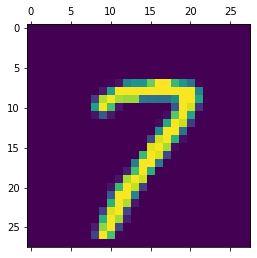

<Figure size 432x288 with 0 Axes>

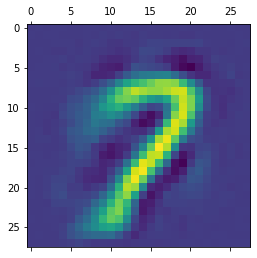

In [9]:
plt.matshow(X[i][0])
plt.figure()
plt.matshow(outputs.detach().numpy())

In [10]:
autoencoder.forward_embedding(X[:10].flatten(start_dim=1))

tensor([[-0.3555, -0.8629, -0.4939, -0.9957,  0.1598, -0.6777,  0.9982, -0.1011,
          0.3224,  0.0586,  0.1904,  0.4778,  1.4644,  1.5863, -0.8079],
        [ 0.6735,  0.8023, -1.1139, -0.2013, -1.3227,  0.6545,  0.3051,  1.0556,
         -0.7515, -0.9177,  0.3329,  0.6882,  1.7972,  1.2451, -1.7195],
        [ 0.7710,  0.2954,  0.0221, -0.7062,  0.1681,  0.1840,  0.3376,  1.0508,
         -0.0881,  0.7225,  1.0356,  0.0098, -0.3032, -0.8421, -0.8764],
        [-0.9068, -0.5979, -0.6365,  1.4502, -0.1365,  0.2502,  0.7062,  0.0223,
          0.2142,  0.8854,  0.0083,  0.1648,  0.2629,  1.1410,  0.2398],
        [-1.1533,  0.0227, -0.6738, -0.5346, -0.5479, -0.1354, -0.8197,  0.9017,
          0.0615,  1.2831,  0.2944, -0.1665,  1.1455,  0.6230,  0.5413],
        [ 0.3841,  0.6766,  0.5406, -0.2841, -0.9218, -0.1458,  0.7329,  1.0221,
          0.7243,  0.7425,  0.6847,  0.3182,  1.0561,  0.8652, -1.5488],
        [-0.7698, -0.8656,  0.4179, -0.5447,  0.5413, -0.4026, -0.2080, -0.4

## add classifier

In [11]:
class LinearClassifier(pl.LightningModule):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.layer0 = nn.Linear(input_size, output_size)
        self.activation0 = nn.Softmax(dim=1)
        self.loss = nn.CrossEntropyLoss()
        

    def forward(self, x):
        # in lightning, forward defines the prediction/inference actions
        output = self.layer0(x)
        output = self.activation0(output)
        return output
    
    def training_step(self, batch, batch_idx):
        # training_step defined the train loop.
        # It is independent of forward
        x, y = batch
        #x = x.view(x.size(0), -1)
        output = self.forward(x)
        loss = self.loss(output, y)
        # Logging to TensorBoard by default
        self.log("train_loss", loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [12]:
# define the linear classifier
lin_class = LinearClassifier(latent_space_dim, 10)

In [13]:
# create its dataset
X_propag = X.flatten(start_dim=1)
embeddings = autoencoder.forward_embedding(X_propag)
embeddings.detach_()
print(embeddings[:10])

# apparently no need
Y_one_hot = F.one_hot(Y).type(torch.FloatTensor)
print(Y_one_hot[:5])

tensor([[-0.3555, -0.8629, -0.4939, -0.9957,  0.1598, -0.6777,  0.9982, -0.1011,
          0.3224,  0.0586,  0.1904,  0.4778,  1.4644,  1.5863, -0.8079],
        [ 0.6735,  0.8023, -1.1139, -0.2013, -1.3227,  0.6545,  0.3051,  1.0556,
         -0.7515, -0.9177,  0.3329,  0.6882,  1.7972,  1.2451, -1.7195],
        [ 0.7710,  0.2954,  0.0221, -0.7062,  0.1681,  0.1840,  0.3376,  1.0508,
         -0.0881,  0.7225,  1.0356,  0.0098, -0.3032, -0.8421, -0.8764],
        [-0.9068, -0.5979, -0.6365,  1.4502, -0.1365,  0.2502,  0.7062,  0.0223,
          0.2142,  0.8854,  0.0083,  0.1648,  0.2629,  1.1410,  0.2398],
        [-1.1533,  0.0227, -0.6738, -0.5346, -0.5479, -0.1354, -0.8197,  0.9017,
          0.0615,  1.2831,  0.2944, -0.1665,  1.1455,  0.6230,  0.5413],
        [ 0.3841,  0.6766,  0.5406, -0.2841, -0.9218, -0.1458,  0.7329,  1.0221,
          0.7243,  0.7425,  0.6847,  0.3182,  1.0561,  0.8652, -1.5488],
        [-0.7698, -0.8656,  0.4179, -0.5447,  0.5413, -0.4026, -0.2080, -0.4

In [14]:
# train the linear classifier on the latent space embedding

train_set = TensorDataset(embeddings, Y)
train_loader_lin = DataLoader(train_set, batch_size=10)

trainer_lin = pl.Trainer(max_epochs=5)
trainer_lin.fit(model=lin_class, train_dataloaders=train_loader_lin)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name        | Type             | Params
-------------------------------------------------
0 | layer0      | Linear           | 160   
1 | activation0 | Softmax          | 0     
2 | loss        | CrossEntropyLoss | 0     
-------------------------------------------------
160       Trainable params
0         Non-trainable params
160       Total params
0.001     Total estimated model params size (MB)


Epoch 4: 100%|██████████| 6000/6000 [00:34<00:00, 176.09it/s, loss=1.56, v_num=1]


In [15]:
Y_pred = lin_class.forward(embeddings)
Y_pred = pd.DataFrame(Y_pred.detach().numpy())
Y_pred["prediction"] = Y_pred.apply(np.argmax, axis=1)
Y_pred

,0,1,2,3,4,5,6,7,8,9,prediction
0,2.566029e-04,1.901775e-07,4.423100e-03,4.794737e-01,1.236053e-07,0.513668,9.143476e-08,5.480229e-05,1.825058e-03,2.978946e-04,5
1,9.998550e-01,8.637199e-15,7.704602e-09,6.903121e-09,2.591673e-10,0.000145,1.509487e-08,1.700323e-09,4.439479e-09,4.022302e-09,0
2,3.946266e-04,6.284402e-09,3.974060e-05,1.873044e-03,8.901767e-01,0.002315,2.754826e-05,1.266611e-04,1.279155e-04,1.049192e-01,4
3,9.560646e-07,9.797935e-01,4.238156e-04,4.196669e-05,5.490799e-07,0.000103,8.316734e-08,9.155373e-06,1.962308e-02,3.900775e-06,1
4,7.143207e-08,6.441237e-06,6.364895e-08,2.888037e-07,6.979869e-02,0.000005,1.918968e-07,1.093730e-03,7.969914e-05,9.290162e-01,9
...,...,...,...,...,...,...,...,...,...,...,...
59995,1.412228e-05,4.112076e-04,2.522292e-04,1.240786e-03,1.424433e-08,0.000317,1.593127e-09,6.997598e-08,9.977548e-01,9.246490e-06,8
59996,2.541252e-06,6.406427e-09,2.935176e-04,9.995240e-01,8.571029e-09,0.000100,8.418880e-11,3.470867e-08,8.000599e-05,2.707163e-07,3
59997,5.481493e-06,2.608225e-07,5.130782e-10,8.544605e-05,2.650473e-09,0.996286,1.631428e-12,4.973289e-07,2.580021e-03,1.042778e-03,5
59998,7.346926e-03,4.372407e-10,1.444865e-04,1.298387e-07,5.052604e-04,0.000080,9.918772e-01,2.776074e-08,1.033295e-07,4.567970e-05,6


0.8561333333333333


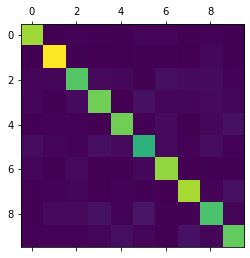

In [16]:
print(accuracy_score(Y, Y_pred.prediction))
conf_mat = confusion_matrix(Y, Y_pred.prediction)
plt.matshow(conf_mat)

## Get the embeddings

In [17]:
# because the embeddings are not calculated through Visualization, each element is present twice
dir_path = '/neurospin/dico/agaudin/Runs/02_explicabilite_humains_2022/Output/2022-05-18/11-00-10'

train_embeddings = pd.read_csv(dir_path+'/train_embeddings.csv', index_col=0)
val_embeddings = pd.read_csv(dir_path+'/val_embeddings.csv', index_col=0)

print(train_embeddings.shape)
print(val_embeddings.shape)


embeddings = pd.concat([train_embeddings, val_embeddings], axis=0, ignore_index=True)
embeddings

FileNotFoundError: [Errno 2] No such file or directory: '/neurospin/dico/agaudin/Runs/02_explicabilite_humains_2022/Output/2022-05-18/11-00-10/train_embeddings.csv'

In [ ]:
embeddings.loc[:, embeddings.columns != 'ID']

,dim1,dim2,dim3,dim4
0,8.607004,10.544548,-1.875861,14.947199
1,6.774639,9.453935,-2.074166,12.493588
2,6.245407,2.204583,-9.917317,2.996176
3,8.898745,3.464000,-8.458150,6.950223
4,8.805327,2.511324,-8.323596,8.753686
...,...,...,...,...
1095,2.615529,-3.292192,-12.578430,1.889788
1096,3.607781,-3.065661,-8.625574,9.827278
1097,3.794838,-2.817605,-8.389682,10.302524
1098,9.012708,0.697612,-9.146828,9.339451


In [ ]:
# take the mean of the two representations
embeddings = embeddings.groupby(['ID']).mean()
embeddings

,dim1,dim2,dim3,dim4
ID,,,,
100307,4.518542,-1.731114,-10.004573,5.222970
100610,14.314068,8.940447,-3.657568,18.687688
101107,10.880040,3.124564,-7.629962,10.815388
101309,0.802435,-5.053474,-11.944574,2.161026
102008,9.271605,0.505080,-8.369234,9.781714
...,...,...,...,...
973770,9.259984,4.759903,-3.897219,17.227477
987074,14.558414,7.464320,-4.294970,19.736421
987983,0.022700,-4.455080,-13.534734,-1.307830


In [16]:
# create and save fake labels to test train_classifier
dir_path = "/neurospin/dico/agaudin/Runs/02_explicabilite_humains_2022/\
Output/2022-05-18/11-00-10//HCP_embeddings/2022-06-02_09-46/"  # should be passed as an argument/ in config
train_embeddings = pd.read_csv(dir_path+'train_embeddings.csv')
val_embeddings = pd.read_csv(dir_path+'val_embeddings.csv')
test_embeddings = pd.read_csv(dir_path+'test_embeddings.csv')

embeddings = pd.concat([train_embeddings, val_embeddings, test_embeddings],
                        axis=0, ignore_index=True)
print(embeddings.iloc[:10,:])
embeddings.sort_values(by='ID', inplace=True)

ids = embeddings.ID.values

labels = pd.DataFrame({'ID': ids,
                       'label': np.random.randint(0,2,len(ids))})
labels.to_csv("fake_labels.csv", index=False)

       ID       dim1      dim2       dim3       dim4
0  100307   6.477329 -0.436643  -9.119338   7.421880
1  100610  14.444921  8.911864  -3.651662  18.372393
2  101309   1.129477 -4.642883 -11.541558   2.656375
3  102008   9.547610  0.861190  -8.132600   9.999138
4  102513  -1.082993  3.021088  -2.296811   3.171185
5  102614  -2.374028 -6.171038 -10.997260   2.295924
6  102816   2.601914  6.560498  -3.074540   5.262527
7  103010  -3.172067  2.569779  -3.531406  -0.579612
8  103111   0.876065  4.510923  -2.327054   5.522014
9  103212  10.059073  1.932676  -7.068737  11.977123


In [17]:
# generate fake labels

labels = np.random.randint(0,2,embeddings.shape[0])
labels = torch.from_numpy(labels).type(torch.FloatTensor)
print(labels[:10])

# change dtype of embeddings for the next cells to work
dims = ['dim'+str(i+1) for i in range(4)]
embeddings = torch.from_numpy(embeddings[dims].values).type(torch.FloatTensor)
embeddings

tensor([1., 1., 1., 1., 1., 0., 0., 1., 1., 0.])


tensor([[13.2117, 11.2143, -3.3737, 18.4230],
        [ 6.4773, -0.4366, -9.1193,  7.4219],
        [15.4597,  9.9559, -4.3065, 19.0206],
        ...,
        [ 8.7779, 11.1612, -2.6221, 13.5294],
        [11.4028,  4.3753, -7.2452, 10.8691],
        [11.7532,  4.4342, -6.3526, 13.1040]])

In [20]:
# create classifier

class BinaryClassifier(pl.LightningModule):
    def __init__(self, input_size, output_size, activation=None):
        super().__init__()
        self.layer0 = nn.Linear(input_size, output_size)
        if activation == 'sigmoid':
            self.activation = nn.Sigmoid()
        else:
            self.activation = None
        self.loss = nn.MSELoss()
        

    def forward(self, x):
        # in lightning, forward defines the prediction/inference actions
        output = self.layer0(x)
        if self.activation:
            output = self.activation(output)
        return output
    
    def training_step(self, batch, batch_idx):
        # training_step defined the train loop.
        # It is independent of forward
        x, y = batch
        #x = x.view(x.size(0), -1)
        output = self.forward(x)
        loss = self.loss(output.reshape(y.shape), y)
        # Logging to TensorBoard by default
        self.log("train_loss", loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [25]:
class BinaryClassifier2(pl.LightningModule):
    def __init__(self, layers_sizes, activation=None, loss='MSE'):
        super().__init__()
        self.layers = nn.Sequential()
        for i in range(len(layers_sizes)-1):
            #self.layers.append(nn.Linear(layers_sizes[i], layers_sizes[i+1]))
            self.layers.add_module('layer%d'%(i), nn.Linear(layers_sizes[i], layers_sizes[i+1]))

        if activation == 'sigmoid':
            self.activation = nn.Sigmoid()
        else:
            self.activation = None
        
        if loss == 'BCE':
            self.loss = nn.BCELoss()
        else:
            self.loss = nn.MSELoss()
        

    def forward(self, x):
        # in lightning, forward defines the prediction/inference actions
        for layer in self.layers:
            x = layer(x)
        if self.activation:
            x = self.activation(x)
        return x
    
    def training_step(self, batch, batch_idx):
        # training_step defined the train loop.
        # It is independent of forward
        x, y = batch
        #x = x.view(x.size(0), -1)
        output = self.forward(x)
        loss = self.loss(output, y)
        # Logging to TensorBoard by default
        self.log("train_loss", loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [26]:
#bin_class = BinaryClassifier(4,1)
bin_class = BinaryClassifier2([4,1])

train_set = TensorDataset(embeddings, labels)
train_loader_lin = DataLoader(train_set, batch_size=10)

trainer_lin = pl.Trainer(max_epochs=5)
trainer_lin.fit(model=bin_class, train_dataloaders=train_loader_lin)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name   | Type       | Params
--------------------------------------
0 | layers | Sequential | 5     
1 | loss   | MSELoss    | 0     
--------------------------------------
5         Trainable params
0         Non-trainable params
5         Total params
0.000     Total estimated model params size (MB)
/neurospin/dico/agaudin/Runs/02_explicabilite_humains_2022/2022_jchavas_cingulate_inhibitory_control/venv_local/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Epoch 0:  19%|█▉        | 21/112 [00:00<00:00, 135.99it/s, loss=9.89, v_num=4]

/neurospin/dico/agaudin/Runs/02_explicabilite_humains_2022/2022_jchavas_cingulate_inhibitory_control/venv_local/lib/python3.6/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1:  18%|█▊        | 20/112 [00:00<00:00, 118.30it/s, loss=2.52, v_num=4] 

/neurospin/dico/agaudin/Runs/02_explicabilite_humains_2022/2022_jchavas_cingulate_inhibitory_control/venv_local/lib/python3.6/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 4: 100%|██████████| 112/112 [00:01<00:00, 90.77it/s, loss=0.659, v_num=4] 


In [ ]:
for layer in bin_class.layers:
    print(layer)

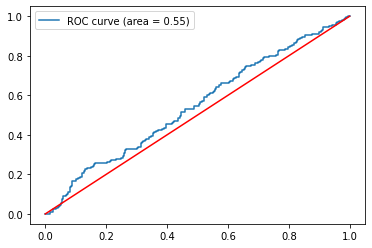

In [ ]:
labels_pred = bin_class.forward(embeddings)
labels_pred = labels_pred.detach().numpy()
curves = roc_curve(labels.detach_().numpy(), labels_pred)
roc_auc = roc_auc_score(labels.detach_().numpy(), labels_pred)

plt.plot(curves[0], curves[1], label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0,1],[0,1],color='r')
plt.legend()

## Data format ACCpatterns

Alacool, faut juste utiliser read_labels

In [4]:
dir_path = "/neurospin/dico/agaudin/Runs/02_explicabilite_humains_2022/Output/2022-05-18/11-00-10/ACCpatterns_embeddings/03_monkeys"
labels_path = "/neurospin/dico/data/bv_databases/human/partially_labeled/ACCpatterns/all.csv"

train_embeddings = pd.read_csv(dir_path+'/train_embeddings.csv', index_col=0)
val_embeddings = pd.read_csv(dir_path+'/val_embeddings.csv', index_col=0)
test_embeddings = pd.read_csv(dir_path+'/test_embeddings.csv', index_col=0)

n_train = train_embeddings.shape[0]
n_val = val_embeddings.shape[0]
n_test = test_embeddings.shape[0]

# regroup them in one dataframe (discuss with Joël)
embeddings = pd.concat([train_embeddings, val_embeddings, test_embeddings],
                        axis=0, ignore_index=False)
print("embeddings:", embeddings.head())
embeddings.sort_values(by='ID', inplace=True)

# get the labels (0 = no paracingulate, 1 = paracingulate)
# /!\ use read_labels
labels = read_labels("/neurospin/dico/data/bv_databases/human/partially_labeled/ACCpatterns/all.csv",
                'long_name', ["Right_PCS"])
labels.head()

INFO:utils.py: Labels to keep = ['Right_PCS'] of type <class 'list'>
INFO:utils.py: Column Right_PCS sorted as categories. Categories are Index(['absent', 'present'], dtype='object')
INFO:utils.py: Head of subject_labels:
            Subject  Right_PCS
0  nih_chp_04701_t1          0
1  nih_chp_01534_t1          1
2  nih_chp_04623_t1          1
3  nih_chp_01503_t1          0
4  nih_chp_00404_t1          1
INFO:utils.py: Number of non-NaN subjects with label = 341


embeddings:                    dim1       dim2      dim3       dim4
ID                                                     
1-15LEHMI_t0   0.376697   4.871498 -2.782840   4.977815
1-17COLMA_t0   7.505823   8.754855 -2.106352  15.098188
1-18ROUCO_t0  14.609875  12.999657 -3.187456  20.404272
1-40AYMJU_t0  -4.110221   2.288045 -3.719156  -1.692169
2-02FERMA_t0  13.239660   8.982064 -6.034750  13.343290


,Subject,Right_PCS
0,nih_chp_04701_t1,0
1,nih_chp_01534_t1,1
2,nih_chp_04623_t1,1
3,nih_chp_01503_t1,0
4,nih_chp_00404_t1,1


In [45]:
labels = pd.DataFrame(labels.values, columns=['ID', 'label'])
labels.head()

,ID,label
0,nih_chp_04701_t1,0
1,nih_chp_01534_t1,1
2,nih_chp_04623_t1,1
3,nih_chp_01503_t1,0
4,nih_chp_00404_t1,1


## look at classifier repartition

In [40]:
csv_path = "/neurospin/dico/agaudin/Runs/02_explicabilite_humains_2022/Output/2022-06-02/16-55-07/ACCpatterns_embeddings/03_monkeys/sigmoid/labels.csv"

df = pd.read_csv(csv_path, index_col=0)
df

,Subject,label,predicted
0,nih_chp_04701_t1,0,0.473889
1,nih_chp_01534_t1,1,0.366470
2,nih_chp_04623_t1,1,0.303456
3,nih_chp_01503_t1,0,0.294406
4,nih_chp_00404_t1,1,0.401942
...,...,...,...
336,a0005_t1_s03,1,0.364412
337,a0006_t1_s03,0,0.194246
338,a0001_t1_s03,1,0.477221
339,a0016_t1_s03,1,0.182778


144 - 197
0 1


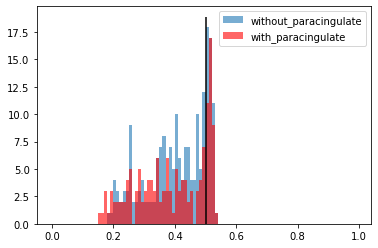

In [41]:
with_paracingulate = df[df.label == 1]
without_paracingulate = df[df.label == 0]

print(with_paracingulate.shape[0], "-", without_paracingulate.shape[0])

x_min = min(0, np.min(df.predicted))
x_max = max(1, np.max(df.predicted))

print(x_min, x_max)

plt.hist(without_paracingulate.predicted, bins=np.arange(x_min,x_max,0.01), alpha=0.6)
plt.hist(with_paracingulate.predicted, bins=np.arange(x_min,x_max,0.01), alpha=0.6, color='r')
plt.legend(['without_paracingulate', "with_paracingulate"])

ax = plt.gca()
plt.vlines([0.5], ax.get_ylim()[0], ax.get_ylim()[1], color='black')
plt.show()

In [42]:
# accuracy if everything is at 0
197/(144+197)

0.5777126099706745

## PCA of embeddings

In [30]:
# import embeddings
dir_path = "/neurospin/dico/agaudin/Runs/02_explicabilite_humains_2022/Output/2022-05-18/11-00-10/ACCpatterns_embeddings/03_monkeys/"

train_embeddings = pd.read_csv(dir_path+'train_embeddings.csv', index_col=0)
val_embeddings = pd.read_csv(dir_path+'val_embeddings.csv', index_col=0)
test_embeddings = pd.read_csv(dir_path+'test_embeddings.csv', index_col=0)

# regroup them in one dataframe (discuss with Joël)
embeddings = pd.concat([train_embeddings, val_embeddings, test_embeddings],
                        axis=0, ignore_index=False)
embeddings.sort_values(by='ID', inplace=True)

embeddings

,dim1,dim2,dim3,dim4
ID,,,,
1-03HUBJO_t0,6.702508,-0.521449,-8.700791,7.263110
1-08ANDTI_t0,10.623695,3.689146,-7.864155,9.724400
1-11LEBJO_t0,7.248810,1.131692,-9.325620,5.343402
1-15LEHMI_t0,0.376697,4.871498,-2.782840,4.977815
1-17COLMA_t0,7.505823,8.754855,-2.106352,15.098188
...,...,...,...,...
sub-inhibition25_ses-pretraining_T1w,10.430673,9.679270,-2.118162,18.727474
sub-inhibition26_ses-pretraining_T1w,9.215110,11.493271,-2.754742,13.676187
sub-inhibition28_ses-pretraining_T1w,-0.758684,-3.971905,-7.517027,7.698512


In [32]:
# import labels
labels_path = "/neurospin/dico/data/bv_databases/human/partially_labeled/ACCpatterns/all.csv"
labels = read_labels(labels_path, 'long_name', ["Right_PCS"])
labels = pd.DataFrame(labels.values, columns=['ID', 'label'])
labels.sort_values(by='ID', inplace=True, ignore_index=True)

INFO:utils.py: Labels to keep = ['Right_PCS'] of type <class 'list'>
INFO:utils.py: Column Right_PCS sorted as categories. Categories are Index(['absent', 'present'], dtype='object')
INFO:utils.py: Head of subject_labels:
            Subject  Right_PCS
0  nih_chp_04701_t1          0
1  nih_chp_01534_t1          1
2  nih_chp_04623_t1          1
3  nih_chp_01503_t1          0
4  nih_chp_00404_t1          1
INFO:utils.py: Number of non-NaN subjects with label = 341


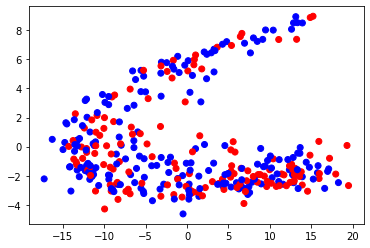

In [33]:
pca = PCA(n_components=2)

d2_embs = pca.fit_transform(embeddings.values)
colors = ['blue', 'red']
plt.scatter(d2_embs[:,0], d2_embs[:,1], c=labels.label, cmap=matplotlib.colors.ListedColormap(colors))

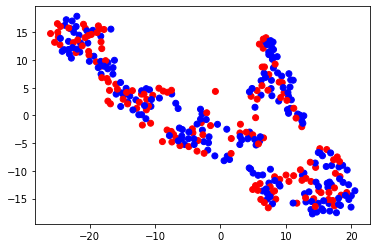

In [34]:
tSNE = TSNE(n_components=2)

d2_embs = tSNE.fit_transform(embeddings.values)
colors = ['blue', 'red']
plt.scatter(d2_embs[:,0], d2_embs[:,1], c=labels.label, cmap=matplotlib.colors.ListedColormap(colors))

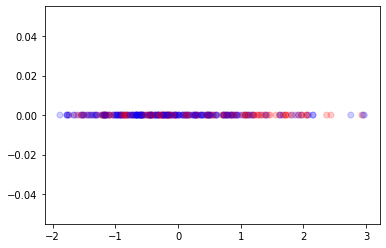

In [35]:
lda = LinearDiscriminantAnalysis(n_components=1)

d2_embs = lda.fit_transform(X=embeddings.values, y=labels.label.values.astype('float32'))
colors = ['blue', 'red']
plt.scatter(d2_embs, [0 for i in range(len(d2_embs))], c=labels.label, cmap=matplotlib.colors.ListedColormap(colors), alpha=0.2)

## Test ROC randomness

In [43]:
# import data

csv_path = "/neurospin/dico/agaudin/Runs/02_explicabilite_humains_2022/Output/2022-06-02/16-55-07/ACCpatterns_embeddings/03_monkeys/linear/labels.csv"

df = pd.read_csv(csv_path, index_col=0)
df

,Subject,label,predicted
0,nih_chp_04701_t1,0,0.499946
1,nih_chp_01534_t1,1,0.336133
2,nih_chp_04623_t1,1,0.244599
3,nih_chp_01503_t1,0,0.228935
4,nih_chp_00404_t1,1,0.332524
...,...,...,...
336,a0005_t1_s03,1,0.279573
337,a0006_t1_s03,0,0.169775
338,a0001_t1_s03,1,0.375984
339,a0016_t1_s03,1,0.147297


In [55]:
# generating random predictions
labels = df.label
accuracies = []
rocs = []

for i in range(500):
    predicted = np.random.rand(341)
    preds = (predicted >= 0.5).astype('int') 
    accuracies.append(accuracy_score(labels, preds))
    rocs.append(roc_auc_score(labels, predicted))

print("accuracy", np.mean(accuracies), np.std(accuracies))
print("auc", np.mean(rocs), np.std(rocs))

accuracy 0.5008152492668622 0.02685434390213146
auc 0.5007959183673469 0.03255289925384528


In [54]:
# shuffling labels
labels = df.label.to_numpy()
predicted = df.predicted
accuracies = []
rocs = []

for i in range(500):
    np.random.shuffle(labels)
    preds = (predicted >= 0.5).astype('int') 
    accuracies.append(accuracy_score(labels, preds))
    rocs.append(roc_auc_score(labels, predicted))


print("accuracy", np.mean(accuracies), np.std(accuracies))
print("auc", np.mean(rocs), np.std(rocs))

accuracy 0.5709442815249268 0.009424918834505826
auc 0.5023525686136524 0.029664385191818608


0.5747800586510264
0.5


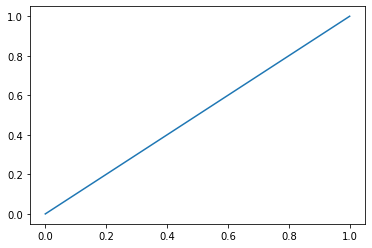

In [57]:
# prediction everything to zero

predicted = np.zeros(341)

print(accuracy_score(df.label, predicted))
print(roc_auc_score(df.label, predicted))

curves = roc_curve(df.label, predicted)
plt.plot(curves[0], curves[1])

In [38]:
# prediction normal centered around 0.3

labels = df.label
accuracies = []
rocs = []

for i in range(500):
    predicted = np.random.normal(0.3, 0.1, 341)
    preds = (predicted >= 0.5).astype('int') 
    accuracies.append(accuracy_score(labels, preds))
    rocs.append(roc_auc_score(labels, predicted))

print("accuracy", np.mean(accuracies), np.std(accuracies))
print("auc", np.mean(rocs), np.std(rocs))

accuracy 0.5739237536656893 0.00816847733554028
auc 0.5002858150028201 0.0294092347373973


Bootstrap #1 ROC area: 0.549
Bootstrap #2 ROC area: 0.556
Bootstrap #3 ROC area: 0.525
Bootstrap #4 ROC area: 0.521
Bootstrap #5 ROC area: 0.563
Bootstrap #6 ROC area: 0.614
Bootstrap #7 ROC area: 0.513
Bootstrap #8 ROC area: 0.551
Bootstrap #9 ROC area: 0.460
Bootstrap #10 ROC area: 0.568
Bootstrap #11 ROC area: 0.550
Bootstrap #12 ROC area: 0.552
Bootstrap #13 ROC area: 0.523
Bootstrap #14 ROC area: 0.525
Bootstrap #15 ROC area: 0.536
Bootstrap #16 ROC area: 0.595
Bootstrap #17 ROC area: 0.558
Bootstrap #18 ROC area: 0.516
Bootstrap #19 ROC area: 0.547
Bootstrap #20 ROC area: 0.534
Bootstrap #21 ROC area: 0.556
Bootstrap #22 ROC area: 0.547
Bootstrap #23 ROC area: 0.515
Bootstrap #24 ROC area: 0.501
Bootstrap #25 ROC area: 0.514
Bootstrap #26 ROC area: 0.587
Bootstrap #27 ROC area: 0.605
Bootstrap #28 ROC area: 0.560
Bootstrap #29 ROC area: 0.549
Bootstrap #30 ROC area: 0.453
Bootstrap #31 ROC area: 0.583
Bootstrap #32 ROC area: 0.596
Bootstrap #33 ROC area: 0.491
Bootstrap #34 ROC a

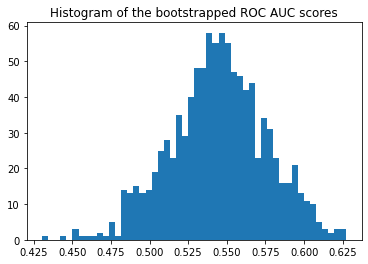

In [59]:
#https://stackoverflow.com/questions/19124239/scikit-learn-roc-curve-with-confidence-intervals

labels = df.label
predicted = df.predicted

n_bootstraps = 1000
rng_seed = 42  # control reproducibility
bootstrapped_scores = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(predicted), len(predicted))
    if len(np.unique(labels[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue

    score = roc_auc_score(labels[indices], predicted[indices])
    bootstrapped_scores.append(score)
    print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, score))


plt.hist(bootstrapped_scores, bins=50)
plt.title('Histogram of the bootstrapped ROC AUC scores')
plt.show()

## multiple_classifier

In [39]:
different_train = "/neurospin/dico/agaudin/Runs/02_explicabilite_humains_2022/Output/2022-05-18/11-00-10/ACCpatterns_embeddings/03_monkeys/1000/predicted_labels.csv"
same_train = "/neurospin/dico/agaudin/Runs/02_explicabilite_humains_2022/Output/2022-06-02/16-55-07/ACCpatterns_embeddings/03_monkeys/1000/predicted_labels.csv"

df = pd.read_csv(different_train, index_col=0)

df.head()

,Subject,label,predicted_0,predicted_1,predicted_2,predicted_3,predicted_4,predicted_5,predicted_6,predicted_7,...,predicted_990,predicted_991,predicted_992,predicted_993,predicted_994,predicted_995,predicted_996,predicted_997,predicted_998,predicted_999
0,nih_chp_04701_t1,0,0.418341,0.545734,0.627331,0.181636,0.306725,0.424233,0.342775,0.610112,...,0.682893,0.424334,0.266349,0.457542,0.296441,0.353059,0.470653,0.067257,0.463732,0.508353
1,nih_chp_01534_t1,1,0.349388,0.677922,0.543573,0.005526,0.158271,0.566067,0.320633,0.414007,...,0.803183,0.467758,-0.044611,0.264595,0.171363,0.256693,0.410211,0.128191,0.558193,0.567764
2,nih_chp_04623_t1,1,0.372321,0.664113,0.479416,0.173098,0.225754,0.590368,0.359228,0.319519,...,0.722121,0.482197,0.000868,0.244056,0.246601,0.311236,0.418218,0.380077,0.551490,0.581016
3,nih_chp_01503_t1,0,0.216883,0.139933,-0.194613,1.228174,0.391701,0.100803,0.139117,-0.236873,...,-0.648754,0.315631,0.791391,0.139715,0.374825,0.311624,0.297590,1.367912,-0.123653,0.236076
4,nih_chp_00404_t1,1,0.145942,0.135486,0.055438,0.972358,0.252164,0.207346,0.199812,0.146521,...,-0.412406,0.368453,0.877479,0.406503,0.233480,0.198823,0.380515,0.921542,0.008209,0.248326


144 - 197
-0.5 1.5


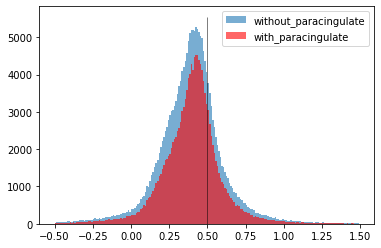

In [43]:
with_paracingulate = df[df.label == 1]
without_paracingulate = df[df.label == 0]

print(with_paracingulate.shape[0], "-", without_paracingulate.shape[0])

list_cols = ['predicted_'+str(i) for i in range(1000)]
predictions_without = without_paracingulate[list_cols].values.flatten()
predictions_with = with_paracingulate[list_cols].values.flatten()

x_min = max(-0.5, min(0, np.min(predictions_with), np.min(predictions_without)))
x_max = min(1.5, max(1, np.max(predictions_with), np.max(predictions_without)))

print(x_min, x_max)

plt.hist(predictions_without, bins=np.arange(x_min,x_max,0.01), alpha=0.6)
plt.hist(predictions_with, bins=np.arange(x_min,x_max,0.01), alpha=0.6, color='r')
plt.legend(['without_paracingulate', "with_paracingulate"])

ax = plt.gca()
plt.vlines([0.5], ax.get_ylim()[0], ax.get_ylim()[1], color='black', linewidth=0.5)
plt.show()

In [34]:
predictions_without = without_paracingulate[list_cols].values.flatten()
predictions_with = with_paracingulate[list_cols].values.flatten()

print("without", predictions_without.mean())
print("with:", predictions_with.mean())

stats.ttest_ind(predictions_without, predictions_with)

without 0.38651353325284005
with: 0.39399784387128717


Ttest_indResult(statistic=-9.679426670428139, pvalue=3.712094445760449e-22)